#Project Overview: Urdu Deepfake Audio Detection
This notebook implements a machine learning pipeline to detect deepfake (synthetic) Urdu audio using the CSALT-LUMS dataset. It extracts three types of audio features — MFCC, Mel Spectrogram, and Chroma — from .wav files labeled as either bonafide (real) or spoofed (fake).

#The pipeline includes:

Loading and labeling audio files from Google Drive

Extracting features using librosa

Training two models: Logistic Regression and SVM (RBF kernel)

Evaluating performance using accuracy, precision, recall, F1-score, AUC, confusion matrices, and visual plots

This approach allows for comparison across different feature types to identify the most effective representations for Urdu deepfake detection.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import Libraries
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_score, recall_score, f1_score, roc_auc_score,
    RocCurveDisplay
)

In [4]:
# Dataset Path
DATASET_PATH = '/content/drive/MyDrive/deepfake_detection_dataset_urdu'


In [5]:
# Load File Paths and Labels
def get_audio_paths_and_labels(dataset_path):
    wav_files = []
    labels = []
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                if "Bonafide" in file_path:
                    label = 0
                elif "Tacotron" in file_path or "VITS" in file_path:
                    label = 1
                else:
                    continue
                wav_files.append(file_path)
                labels.append(label)
    return wav_files, labels

file_paths, labels = get_audio_paths_and_labels(DATASET_PATH)


In [6]:
# Feature Extraction Functions
def extract_mfcc(file_path, sr=16000, n_mfcc=13):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)

def extract_mel(file_path, sr=16000, n_mels=40):
    y, sr = librosa.load(file_path, sr=sr)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel)
    return np.mean(mel_db, axis=1)

def extract_chroma(file_path, sr=16000):
    y, sr = librosa.load(file_path, sr=sr)
    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.mean(chroma, axis=1)

def extract_features(file_paths, feature_type='mfcc'):
    features = []
    for path in tqdm(file_paths, desc=f"Extracting {feature_type.upper()}"):
        try:
            if feature_type == 'mfcc':
                feat = extract_mfcc(path)
            elif feature_type == 'mel':
                feat = extract_mel(path)
            elif feature_type == 'chroma':
                feat = extract_chroma(path)
            features.append(feat)
        except Exception as e:
            print(f"Error processing {path}: {e}")
    return np.array(features)


In [7]:
# Train and Evaluate with Plots
def train_and_evaluate_svm(X, y, feature_name):
    print(f"\nTraining SVM on {feature_name.upper()} Features")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = SVC(kernel='rbf', probability=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    auc = roc_auc_score(y_test, y_proba)

    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    print("\n--- Classification Metrics ---")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(f"AUC      : {auc:.4f}")
    print("\nConfusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Bonafide", "Fake"], yticklabels=["Bonafide", "Fake"])
    plt.title(f"{feature_name.upper()} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Class-wise Metrics Bar Chart
    labels_str = ["0", "1"]
    metrics = ["precision", "recall", "f1-score"]
    metric_values = {m: [report[l][m] for l in labels_str] for m in metrics}

    x = np.arange(len(labels_str))
    width = 0.25

    plt.figure(figsize=(8, 4))
    for idx, m in enumerate(metrics):
        plt.bar(x + idx * width, metric_values[m], width, label=m)

    plt.xticks(x + width, ['Bonafide (0)', 'Fake (1)'])
    plt.ylim(0, 1.1)
    plt.title(f"{feature_name.upper()} - Precision, Recall, F1 per Class")
    plt.legend()
    plt.show()

    # ROC Curve
    try:
        RocCurveDisplay.from_estimator(model, X_test, y_test)
        plt.title(f"{feature_name.upper()} - ROC Curve")
        plt.show()
    except Exception as e:
        print(f"Couldn't plot ROC curve: {e}")

MFCC:

Extracting MFCC: 100%|██████████| 5108/5108 [21:16<00:00,  4.00it/s]



Training SVM on MFCC Features

--- Classification Metrics ---
Accuracy : 0.9227
Precision: 0.9235
Recall   : 0.9044
F1-Score : 0.9128
AUC      : 0.9586

Confusion Matrix:
[[644  24]
 [ 55 299]]


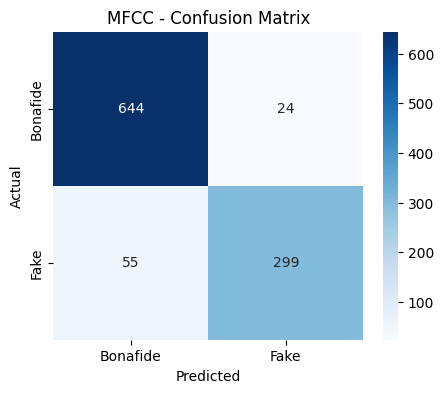

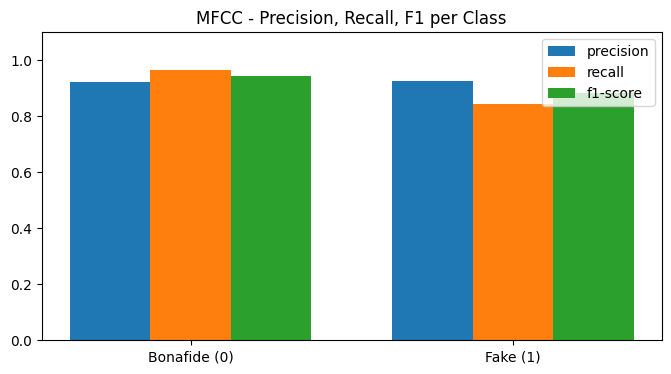

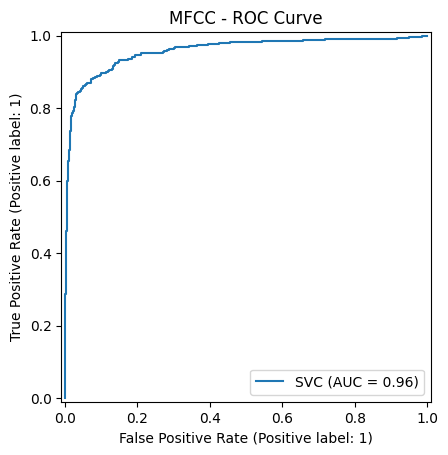

In [8]:
X_mfcc = extract_features(file_paths, 'mfcc')
train_and_evaluate_svm(X_mfcc, labels, 'mfcc')

Mel Spectrogram


Extracting MEL: 100%|██████████| 5108/5108 [02:36<00:00, 32.54it/s]



Training SVM on MEL Features

--- Classification Metrics ---
Accuracy : 0.9697
Precision: 0.9744
Recall   : 0.9589
F1-Score : 0.9660
AUC      : 0.9929

Confusion Matrix:
[[664   4]
 [ 27 327]]


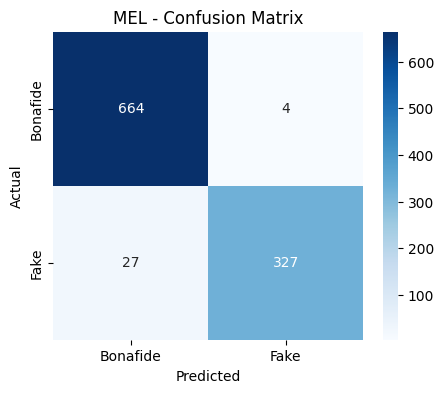

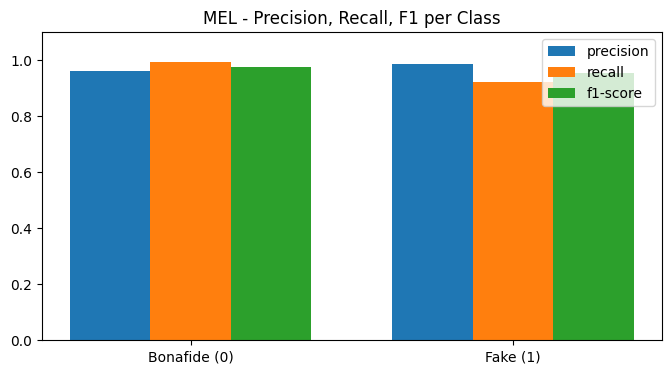

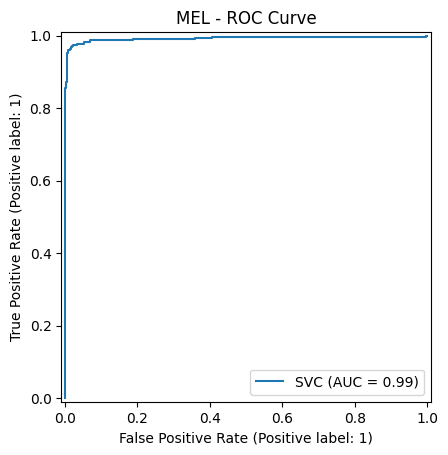

In [9]:
X_mel = extract_features(file_paths, 'mel')
train_and_evaluate_svm(X_mel, labels, 'mel')

Chroma

Extracting CHROMA: 100%|██████████| 5108/5108 [04:09<00:00, 20.44it/s]



Training SVM on CHROMA Features

--- Classification Metrics ---
Accuracy : 0.9286
Precision: 0.9407
Recall   : 0.9029
F1-Score : 0.9179
AUC      : 0.9717

Confusion Matrix:
[[659   9]
 [ 64 290]]


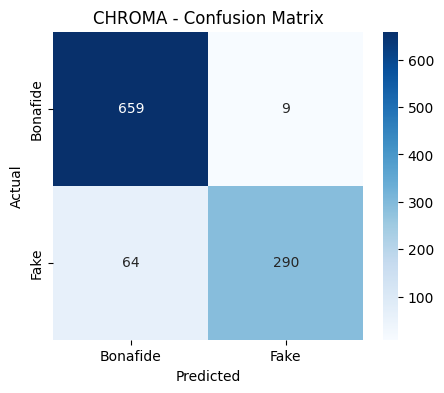

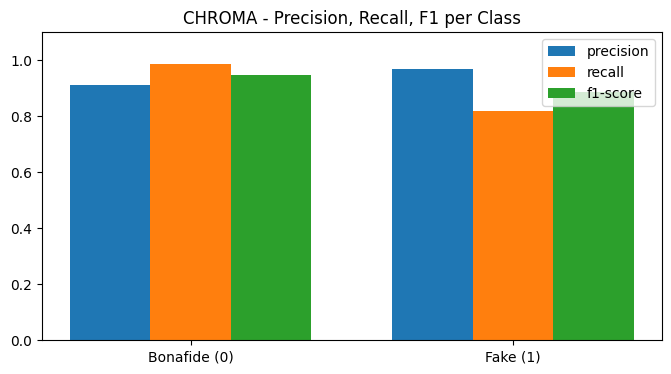

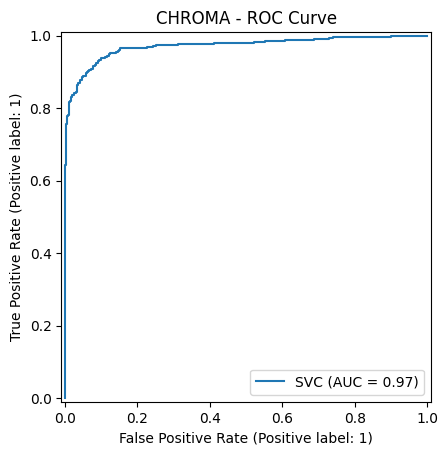

In [10]:
X_chroma = extract_features(file_paths, 'chroma')
train_and_evaluate_svm(X_chroma, labels, 'chroma')

#Final Evaluation Report: SVM on Urdu Deepfake Detection
This report summarizes the performance of Support Vector Machine (SVM) classifiers trained on three different audio feature sets: MFCC, Mel Spectrogram, and Chroma, for detecting deepfake (synthetically generated) Urdu audio.

#Summary of Results
Feature	Accuracy	Precision	Recall	F1-Score	AUC
MFCC	92.27%	92.35%	90.44%	91.28%	95.86%
Mel Spectrogram	96.97%	97.44%	95.89%	96.60%	99.29%
Chroma	92.86%	94.07%	90.29%	91.79%	97.17%

#Key Observations
Mel Spectrogram features provided the best overall performance across all metrics, including the highest AUC.

MFCC and Chroma features also performed well, but with slightly lower recall and more misclassifications compared to Mel.

The Mel feature set resulted in fewer false positives and false negatives, indicating strong model confidence and generalization.

#Conclusion
Mel Spectrograms are the most effective standalone feature type for deepfake audio detection in Urdu using SVM. Future work can involve feature fusion (e.g., MFCC + Mel), hyperparameter tuning, or applying deep learning methods to further improve detection performance.

